In [1]:
import numpy as np
from sklearn.ensemble import IsolationForest as IForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle
import torch
import torch.nn as nn
from global_var import *
from normalize import *
from utils import *
from data_load import load_data
from AE import AutoEncoder
from VAE import VAE
import ExtBound
import KITree
import importlib

/home/lry/anaconda3/envs/pytorchgpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(KITree)

<module 'KITree' from './src/KITree.py'>

In [3]:
dataset = 'cicids_custom'
subset = 'Tuesday'

dataset = 'toniot_custom'
subset = 'ddos'

In [4]:
X, _, y, _ = load_data(dataset, subset, mode='train')
X = X[y == 0]
y = y[y == 0]
X_test, y_test = load_data(dataset, subset, mode='test')
print(X.shape[0], X_test.shape[0])

3050 67046


In [5]:
def print_metrics(y_true, y_pred, y_model):
    prec, rec, f1 = precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
    fid = (y_pred == y_model).sum() / y_pred.shape[0]
    tpr = TP(y_true, y_pred) / (y_true == 1).sum()
    tnr = TN(y_true, y_pred) / (y_true == 0).sum()
    print('prec:', prec, 'rec:', rec, 'f1:', f1, 'tpr', tpr, 'tnr', tnr, 'fid:', fid)
    return prec, rec, f1, tpr, tnr, fid

In [6]:
with open(os.path.join(TARGET_MODEL_DIR, f'IForest_{dataset}_{subset}.model'), 'rb') as f:
    model_SVM = pickle.load(f)
with open(os.path.join(NORMALIZER_DIR, f'{dataset}_{subset}.norm'), 'rb') as f:
    normalizer_SVM = pickle.load(f)
X_SVM = normalizer_SVM.transform(X)
X_test_SVM = normalizer_SVM.transform(X_test)

In [7]:
score_SVM = -model_SVM.score_samples(X_SVM)
thres_SVM = -model_SVM.offset_
func_SVM = lambda x: -model_SVM.score_samples(x)
thres_SVM

0.5921891293109696

In [8]:
kdt_SVM = KITree.KITree(func_SVM, thres_SVM)
kdt_SVM.fit(X_SVM, score_SVM)

In [9]:
y_pred = kdt_SVM.predict(X_test_SVM)
print(TP(y_test, y_pred) / (y_test == 1).sum(), FP(y_test, y_pred) / (y_test == 0).sum())

1.0 0.0260950605778192


In [10]:
y_model = model_SVM.predict(X_test_SVM)
y_model[y_model == 1] = 0
y_model[y_model == -1] = 1
print_metrics(y_test, y_pred, y_model)

prec: 0.9995757640035757 rec: 1.0 f1: 0.9997878369981967 tpr 1.0 tnr 0.9739049394221808 fid: 0.987948572621782


(0.9995757640035757,
 1.0,
 0.9997878369981967,
 1.0,
 0.9739049394221808,
 0.987948572621782)

In [11]:
output_rules = kdt_SVM.get_rules(CUSTOM_FEAT_COLS, normalizer_SVM)

In [12]:
pred_subrules, predict_rules = kdt_SVM.predict_rule_out(X_test_SVM[y_test == 1][5], normalizer_SVM, CUSTOM_FEAT_COLS)

In [13]:
import re
def extract_thresholds_from_rules1(pred_rules):
    rules_info = []

    for line in pred_rules:
        match = re.match(r"dim (\d+) feat (\w+) (exceed upper bound|under lower bound): ([\d.]+)\s*(<|<=|>|>=)\s*([\d.]+)", line)

        if match:
            feature_id = int(match.group(1))
            feature_name = match.group(2)
            comparison_type = match.group(3)
            threshold = float(match.group(6))
            value = float(match.group(4))
            comparison = match.group(5)

            if comparison_type == "exceed upper bound":
                if comparison == "<":
                    comparison = ">="
            else:
                if comparison == ">":
                    comparison = "<="

            rule_info = {
                "feature_id": feature_id,
                "feature_name": feature_name,
                "comparison": comparison,
                "value": value,
                "threshold": threshold,
            }

            rules_info.append(rule_info)

    # 使用集合来删除重复项
    unique_rules_info = list({(info['feature_id'], info['feature_name'], info['comparison'], info['value'], info['threshold']): info for info in rules_info}.values())

    return unique_rules_info

rules_info = extract_thresholds_from_rules1(predict_rules)

In [14]:
predict_rules = kdt_SVM.predict_rule_out(X_test_SVM[y_test == 1][5], normalizer_SVM, CUSTOM_FEAT_COLS)
score_SVM = -model_SVM.score_samples(X_test_SVM)

In [15]:
print('predict_rules = ', predict_rules)
print('predict_rules = ', type(predict_rules))
print('predict_rules = ', len(predict_rules))
permutation_feature_importance = kdt_SVM.permutation_feature_importance_with_rules( pre_model=model_SVM, x = X_test_SVM[y_test == 1][5], rules = predict_rules)
print("permutation_feature_importance.len  =  ", len(permutation_feature_importance))
for key in permutation_feature_importance.keys():
    print(key, ":", permutation_feature_importance[key])

predict_rules =  ([{'feature_id': 18, 'feature_name': 'iat_var', 'comparison': '<=', 'value': -0.24304923318287636, 'threshold': 0.05657056090172502}, {'feature_id': 6, 'feature_name': 'ps_var', 'comparison': '>', 'value': 0.22347521606881068, 'threshold': 107714.33238059204}, {'feature_id': 0, 'feature_name': 'count', 'comparison': '<=', 'value': -4.8778439499444, 'threshold': 423.6839344262295}], [{'feature_id': 0, 'feature_name': 'count', 'comparison': '<', 'value': 14.0, 'threshold': 45.09155100846954}, {'feature_id': 1, 'feature_name': 'fwd_count', 'comparison': '<', 'value': 7.999999999999972, 'threshold': 23.921834027812025}, {'feature_id': 2, 'feature_name': 'bwd_count', 'comparison': '<', 'value': 6.000000000000028, 'threshold': 17.109522699931233}, {'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<', 'value': 199.42857142857144, 'threshold': 17.109522699931233}, {'feature_id': 4, 'feature_name': 'ps_max', 'comparison': '<', 'value': 1406.0, 'threshold': 1454.608390

TypeError: list indices must be integers or slices, not str

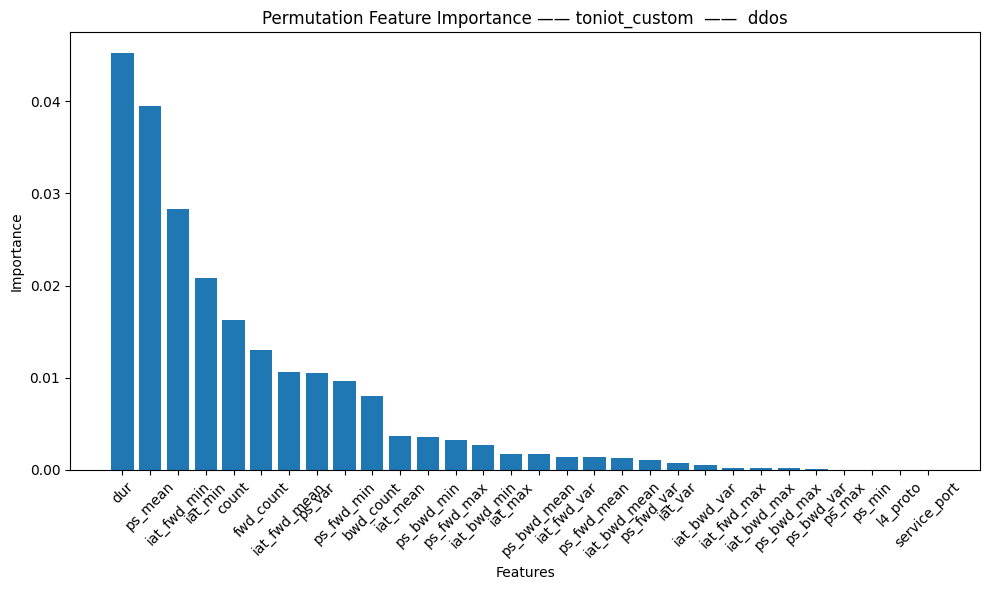

In [ ]:
feature_names = list(permutation_feature_importance.keys())
importance_values = list(permutation_feature_importance.values())

plot_feature_importances(importance_values, feature_names, 'Permutation Feature Importance —— toniot_custom  ——  ddos')

In [ ]:
X_test, y_test = load_data(dataset, subset, mode='test')
print(X.shape[0], X_test.shape[0])

with open(os.path.join(NORMALIZER_DIR, f'{dataset}_{subset}.norm'), 'rb') as f:
    normalizer = pickle.load(f)

X_test = delete_feature(X_test, permutation_feature_importance.keys())

X_test = normalizer.transform(X_test.astype(int))

y_model = model_SVM.predict(X_test_SVM)
y_model[y_model == 1] = 0
y_model[y_model == -1] = 1
print_metrics(y_test, y_pred, y_model)

print(" ==================== predicted_labels distribution ==================== ")
print_class_distribution(y_model)

# Evaluate the predictions
print(" ==================== Evaluate the predictions ==================== ")
evaluate_predictions(y_test, y_model)

3050 67046
prec: 0.9995757640035757 rec: 1.0 f1: 0.9997878369981967 tpr 1.0 tnr 0.9739049394221808 fid: 0.987948572621782
 ==================== predicted_labels distribution ==================== 
Class distribution:
Class 1: 97.24%
Class 0: 2.76%
 ==================== Evaluate the predictions ==================== 
Confusion matrix:
[[ 1056    17]
 [  795 65178]]
TP :  0.9879496157518985
FP :  0.015843429636533086
TN :  0.9841565703634669
FN :  0.012050384248101497
Accuracy: 0.9878889120902067
Precision: [0.57050243 0.99973924]
Recall: [0.98415657 0.98794962]
F1 Score: [0.72229822 0.99380947]


In [ ]:
def eval_features(X_test, y_test, model, normalizer, permutation_feature_importance):
    X_test_N = normalizer.transform(X_test)
    pred_X_test = model.predict(X_test_N)

    X_test = delete_feature(X_test, permutation_feature_importance.keys())
    X_test_N = normalizer.transform(X_test)
    pred_X_test_N = model.predict(X_test_N)

    num = 0
    for i in range(len(pred_X_test)):
        if pred_X_test[i] != pred_X_test_N[i]:
            num += 1

        if pred_X_test[i] == y_test[i] and  pred_X_test_N[i] != y_test[i]:
            num += 1
    return num / len(pred_X_test)

In [17]:
kdt_SVM.predict_rule(X_test_SVM[y_test == 1][5], normalizer_SVM, CUSTOM_FEAT_COLS)

-> dim 18 feat iat_var <= 0.05657056090172502
 -> dim 6 feat ps_var > 107714.33238059204
  -> dim 0 feat count <= 423.6839344262295
   -> dim 0 feat count <= 423.6839344262295
    -> dim 0 feat count <= 423.6839344262295
dim 0 feat count under lower bound: 14.0 < 46.60539537940639
dim 1 feat fwd_count under lower bound: 7.999999999999972 < 21.635677027600593
dim 2 feat bwd_count under lower bound: 6.000000000000028 < 16.713292835334926
dim 4 feat ps_max under lower bound: 1406.0 < 1478.1040334444822
dim 14 feat ps_bwd_var exceed upper bound: 239785.5555555555 >= 232274.31895350013
dim 15 feat iat_mean under lower bound: 0.026596546173095703 < 0.11058490305297983
dim 16 feat iat_max under lower bound: 0.17421507835388184 < 0.5037286326063704
dim 18 feat iat_var under lower bound: 0.002195547901840997 < 0.012776599261069714
dim 19 feat iat_fwd_mean under lower bound: 0.0493935857500348 < 0.1708889005797481
dim 20 feat iat_fwd_max under lower bound: 0.17421507835388195 < 0.556699890770653

In [100]:
# null + EBE
def null_EBE(func, thres, X_train, score, X_test, y_test, y_model):
    ext = ExtBound.ExtBound(func, thres)
    ext.fit(X_train, score)
    ext.set_bound()
    y_pred = np.zeros(y_test.shape)
    for i, x in enumerate(X_test):
        y_pred[i] = ext.predict_sample(x)
    print('null + EBE:')
    print_metrics(y_test, y_pred, y_model)

In [146]:
# KMeans + EBE
def KMeans_EBE(func, thres, X_train, score, X_test, y_test, y_model):
    cluster = KMeans(n_clusters=3)
    y_cluster = cluster.fit_predict(X_train)
    ext_list = []
    for i in set(y_cluster):
        ext = ExtBound.ExtBound(func, thres)
        ext.fit(X_train, score)
        ext.set_bound()
        ext_list.append(ext)
    y_pred = np.zeros(y_test.shape)
    for i, x in enumerate(X_test):
        y_pred[i] = ext.predict_sample(x)
    print('KMeans + EBE:')
    print_metrics(y_test, y_pred, y_model)

In [89]:
class ICTree(KITree.KITree):
    def fit(self, X, s, bound=None):
        self.data = X
        self.score = s
        if type(bound) != np.ndarray:
            self.bound = np.zeros((X.shape[1], 2))
            self.bound[:, 0] = -np.inf
            self.bound[:, 1] = np.inf
        else:
            self.bound = bound
        if self.require_split():
            self.score_norm = self.normalize_score(s)
            # self.cal_label()
            # matrix size: feature size * (sample size - 1)
            criterion_matrix = np.zeros((self.data.shape[1], self.data.shape[0] - 1))
            thres_matrix = np.zeros((self.data.shape[1], self.data.shape[0] - 1))
            # iterate and find feature_id and thres that give maximum criterion
            for i in range(self.data.shape[1]):
                sort_idx = np.argsort(self.data[:, i])
                for j in range(sort_idx.shape[0] - 1):
                    if self.data[sort_idx[j], i] == self.data[sort_idx[j+1], i]:
                        thres_matrix[i, j] = self.data[sort_idx[j], i]
                        criterion_matrix[i, j] = 0
                    else:
                        thres = int((self.data[sort_idx[j+1], i] + self.data[sort_idx[j], i]) / 2.)
                        thres_matrix[i, j] = thres
                        criterion_matrix[i, j] = self.cal_criterion(sort_idx, j)
            max_idx = np.where(criterion_matrix == np.max(criterion_matrix))
            self.feature_id = max_idx[0][0]
            self.feat_thres = thres_matrix[max_idx[0][0], max_idx[1][0]]

            # print('****** Now, the depth of kitree is = ', self.level, ' ****** ')

            # split data and start recursion
            left_idx = self.data[:, self.feature_id] <= self.feat_thres
            right_idx = self.data[:, self.feature_id] > self.feat_thres
            left_bound = self.update_bound(0)
            right_bound = self.update_bound(1)

            self.left = ICTree(self.func, self.func_thres, self.level + 1, n_beam=self.n_beam, rho=self.rho, eta=self.eta)
            self.right = ICTree(self.func, self.func_thres, self.level + 1, n_beam=self.n_beam, rho=self.rho, eta=self.eta)
            self.left.fit(self.data[left_idx], self.score[left_idx], left_bound)
            self.right.fit(self.data[right_idx], self.score[right_idx], right_bound)

        else:
            if self.data.shape[0] == 0:
                self.bound[:, 0] = np.inf
                self.bound[:, 1] = -np.inf
            else:
                self.bound[:, 0] = np.min(self.data, axis=0)
                self.bound[:, 1] = np.max(self.data, axis=0)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            curr = self
            while curr.feature_id != None:
                curr, _ = curr.next_node(x)
            flag = 0
            for k, x_dim in enumerate(x):
                if self.bound[k, 0] <= x_dim <= self.bound[k, 1]:
                    flag += 1
            y_pred[i] = int(flag == x.shape[0])
        return y_pred

In [98]:
def ICTree_hypercube(func, thres, X_train, score, X_test, y_test, y_model):
    KITree.KITree(func, thres)
    ictree = ICTree(func, thres)
    ictree.fit(X_train, score)
    y_pred = ictree.predict(X_test)
    print('ICTree + hypercube:')
    print_metrics(y_test, y_pred, y_model)

In [129]:
null_EBE(func_SVM, thres_SVM, X_SVM, score_SVM, X_test_SVM, y_test, y_model)
KMeans_EBE(func_SVM, thres_SVM, X_SVM, score_SVM, X_test_SVM, y_test, y_model)
ICTree_hypercube(func_SVM, thres_SVM, X_SVM, score_SVM, X_test_SVM, y_test, y_model)

null + EBE:
prec: 0.9990019390897684 rec: 1.0 f1: 0.9995007203891528 tpr 1.0 tnr 0.9655511811023622 fid: 0.9969208577214347
KMeans + EBE:
prec: 0.9990019390897684 rec: 1.0 f1: 0.9995007203891528 tpr 1.0 tnr 0.9655511811023622 fid: 0.9969208577214347
ICTree + hypercube:
prec: 0.9718161391439429 rec: 1.0 f1: 0.9857066486592948 tpr 1.0 tnr 0.0 fid: 0.9699298177480651


In [141]:
ae = torch.load(os.path.join(TARGET_MODEL_DIR, f'AE_{dataset}_{subset}.model')).cuda(DEVICE)
ae.eval()
with open(os.path.join(NORMALIZER_DIR, f'{dataset}_{subset}.norm'), 'rb') as f:
    normalizer_ae = pickle.load(f)
thres_ae = ae.thres
X_ae = normalizer_ae.transform(X)
X_test_ae = normalizer_ae.transform(X_test)

In [142]:
func_ae = lambda x: ae.score_samples(x)
score_ae = func_ae(X_ae)
thres_ae

1.4138606786727905

In [143]:
kdt_ae = KITree.KITree(func_ae, thres_ae)
kdt_ae.fit(X_ae, score_ae)

In [144]:
y_pred = kdt_ae.predict(X_test_ae)
y_model = ae.predict(X_test_ae)
print_metrics(y_test, y_pred, y_model)

prec: 0.9898595943837754 rec: 1.0 f1: 0.9949039592316739 tpr 1.0 tnr 0.974559686888454 fid: 0.9876404494382023


(0.9898595943837754,
 1.0,
 0.9949039592316739,
 1.0,
 0.974559686888454,
 0.9876404494382023)

In [147]:
null_EBE(func_ae, thres_ae, X_ae, score_ae, X_test_ae, y_test, y_model)
KMeans_EBE(func_ae, thres_ae, X_ae, score_ae, X_test_ae, y_test, y_model)
ICTree_hypercube(func_ae, thres_ae, X_ae, score_ae, X_test_ae, y_test, y_model)

null + EBE:
prec: 0.9968553459119497 rec: 0.9992119779353822 f1: 0.9980322707595435 tpr 0.9992119779353822 tnr 0.9921722113502935 fid: 0.9932584269662922
KMeans + EBE:
prec: 0.9968553459119497 rec: 0.9992119779353822 f1: 0.9980322707595435 tpr 0.9992119779353822 tnr 0.9921722113502935 fid: 0.9932584269662922
ICTree + hypercube:
prec: 0.7129213483146067 rec: 1.0 f1: 0.8324040669071827 tpr 1.0 tnr 0.0 fid: 0.7078651685393258


In [ ]:
datasets = {
    'cicids_custom': [
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday'
    ],
    'toniot_custom': [
        'backdoor',
        'ddos',
        'dos',
        'injection',
        'mitm',
        'password',
        'runsomware',
        'scanning',
        'xss'
    ]
}

for d in datasets:
    for sub in datasets[d]:
        print(f'using {d}-{sub}')
        

In [5]:
import re

def extract_rules_info(output_str):
    rules_info = []
    output_lines = output_str.split("\n")
    
    for line in output_lines:
        match = re.match(r"dim (\d+) feat ([\w_]+) (<=|>) ([\d.]+)", line)
        if match:
            rule_info = {
                "feature_id": int(match.group(1)),
                "feature_name": match.group(2),
                "comparison": match.group(3),
                "threshold": float(match.group(4)),
            }
            rules_info.append(rule_info)
    
    # 使用集合来删除重复项
    unique_rules_info = list({(info['feature_id'], info['feature_name'], info['comparison'], info['threshold']): info for info in rules_info}.values())
    
    return unique_rules_info
    return rules_info


output_str = """
dim 3 feat ps_mean <= 239.46641369800085
 -> dim 24 feat iat_bwd_max <= 0.4831280382761515
  -> dim 7 feat ps_fwd_mean <= 291.7064124913988
   -> dim 7 feat ps_fwd_mean <= 291.7064124913988
    -> dim 7 feat ps_fwd_mean <= 291.7064124913988
[[-1.97210174  1.14028537]
 [-2.01791897  1.83967944]
 [-1.83182628  0.65856102]
 [-0.860782   -0.14208559]
 [-1.17379485  0.07457588]
 [-1.20165066  0.82686241]
 [-0.62187437 -0.10615252]
 [-0.74247751 -0.29159982]
 [-0.86204362 -0.03553279]
 [-0.35935767  0.08661789]
 [-0.57977601 -0.32123124]
 [-1.26953438  1.55976055]
 [-1.08698466  1.23211487]
 [-0.6585662   0.50074368]
 [-1.02717689  1.57715796]
 [-0.32836024  0.13907737]
 [-0.64765922 -0.13742273]
 [-2.2311356   4.38703462]
 [-0.1549255   0.15517439]
 [-0.21959886  0.14136407]
 [-0.75971235 -0.12196989]
 [-0.53063679 10.95184005]
 [-0.15400513  0.07881692]
 [-0.36235436  0.20342641]
 [-0.68073824         inf]
 [-0.36359179 14.19781678]
 [-0.16042725  0.04682548]
 [-0.56471687  0.08272792]
 [-0.17580087 -0.02686325]
 [-0.65132762 -0.35003184]]
dim 3 feat ps_mean <= 239.46641369800085
 -> dim 24 feat iat_bwd_max <= 0.4831280382761515
  -> dim 7 feat ps_fwd_mean <= 291.7064124913988
   -> dim 7 feat ps_fwd_mean <= 291.7064124913988
    -> dim 7 feat ps_fwd_mean > 291.7064124913988
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]]
dim 3 feat ps_mean <= 239.46641369800085
 -> dim 24 feat iat_bwd_max <= 0.4831280382761515
  -> dim 7 feat ps_fwd_mean <= 291.7064124913988
   -> dim 7 feat ps_fwd_mean > 291.7064124913988
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]]
dim 3 feat ps_mean <= 239.46641369800085
 -> dim 24 feat iat_bwd_max <= 0.4831280382761515
  -> dim 7 feat ps_fwd_mean > 291.7064124913988
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]]
dim 3 feat ps_mean <= 239.46641369800085
 -> dim 24 feat iat_bwd_max > 0.4831280382761515
  -> dim 15 feat iat_mean <= 0.012303562264015574
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]]
dim 3 feat ps_mean <= 239.46641369800085
 -> dim 24 feat iat_bwd_max > 0.4831280382761515
  -> dim 15 feat iat_mean > 0.012303562264015574
   -> dim 15 feat iat_mean <= 0.012303562264015574
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]]
dim 3 feat ps_mean <= 239.46641369800085
 -> dim 24 feat iat_bwd_max > 0.4831280382761515
  -> dim 15 feat iat_mean > 0.012303562264015574
   -> dim 15 feat iat_mean > 0.012303562264015574
    -> dim 15 feat iat_mean <= 0.012303562264015574
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
 [-inf -inf]
"""
rules_info = extract_rules_info(output_str)
print(rules_info)

[{'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<=', 'threshold': 239.46641369800085}, {'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<=', 'threshold': 239.46641369800085}, {'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<=', 'threshold': 239.46641369800085}, {'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<=', 'threshold': 239.46641369800085}, {'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<=', 'threshold': 239.46641369800085}, {'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<=', 'threshold': 239.46641369800085}, {'feature_id': 3, 'feature_name': 'ps_mean', 'comparison': '<=', 'threshold': 239.46641369800085}]


In [6]:
def print_rules_info(rules_info):
    for rule in rules_info:
        print("feature_id:", rule["feature_id"])
        print("feature_name:", rule["feature_name"])
        print("comparison:", rule["comparison"])
        print("threshold:", rule["threshold"])
        print()
print_rules_info(rules_info)

feature_id: 3
feature_name: ps_mean
comparison: <=
threshold: 239.46641369800085

feature_id: 3
feature_name: ps_mean
comparison: <=
threshold: 239.46641369800085

feature_id: 3
feature_name: ps_mean
comparison: <=
threshold: 239.46641369800085

feature_id: 3
feature_name: ps_mean
comparison: <=
threshold: 239.46641369800085

feature_id: 3
feature_name: ps_mean
comparison: <=
threshold: 239.46641369800085

feature_id: 3
feature_name: ps_mean
comparison: <=
threshold: 239.46641369800085

feature_id: 3
feature_name: ps_mean
comparison: <=
threshold: 239.46641369800085

